<img src="https://raw.githubusercontent.com/deepmind/acme/master/docs/imgs/acme.png" width="50%">

# Acme quickstart guide

This tutorial will walk you through how to construct a basic agent in Acme, define an environment to run that agent in, and finally to define the network architecture that acts as the *glue* between the agent and the environment.

To make running experiments as easy as possible, Acme provides a high level
interface which takes these three components and will run and evaluate the agent. See the figure below for a high-level illustration of this process. 
<!-- If you would like more information on what lies behind this function, take a look at our RL tutorial which walks through the details of how the agent interacts with the environment. -->

<img src="https://raw.githubusercontent.com/deepmind/acme/master/docs/imgs/configure-and-run-experiments.png" width="50%">


In the next few sections we will instantiate and run the D4PG algorithm on a continuous control environment, show the behavior of a trained agent, and plot the performance of this agent over time. While this tutorial is specific to this agent and environment, the same rough, high-level approach can be used for any other Acme algorithm!

---
_Warning! This colab has only been tested with **python 3.8 and 3.9** kernels. 
We are working on making it run on the default 3.7 colab kernel. Please bear with us._

# Import Modules


In [ ]:
from typing import Optional

import collections
from dm_control import suite as dm_suite
import dm_env
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from acme import specs
from acme import wrappers
from acme.agents.jax import d4pg
from acme.jax import experiments
from acme.utils import loggers

# Defining our environment

Next we will need to define the environment in which to run the agent, implemented as a `dm_env.Environment`. In particular, here we will define an environment factory so that we can construct it later (when we run the experiment).

In [2]:
def make_environment(seed: int) -> dm_env.Environment:
  environment = dm_suite.load('cartpole', 'balance')

  # Make the observations be a flat vector of all concatenated features.
  environment = wrappers.ConcatObservationWrapper(environment)

  # Wrap the environment so the expected continuous action spec is [-1, 1].
  # Note: this is a no-op on 'control' tasks.
  environment = wrappers.CanonicalSpecWrapper(environment, clip=True)

  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  return environment

# Creating our neural networks 

Algorithms in Acme typically define a *Networks* datastructure, where networks are responsible for consuming outputs from the environment and translating those into quantities that will be used by the given algorithm. For example, D4PG makes use of

* a deterministic Policy network and
* a distributional Critic network

which are used both for learning and to generate actions. In this case these are defined using the `d4pg.D4PGNetworks` dataclass. Most algorithms define a
*default* set of networks, and so does D4PG as it defines `d4pg.make_networks`. 
These factories should return networks with appropriate input/output sizes
given an `EnvironmentSpec` which specifies the sizes expected by the
environment.

Below we define a custom factory based on the default factory and adjust the
sizes of hidden layers in the MLPs.

In [3]:
def network_factory(spec: specs.EnvironmentSpec) -> d4pg.D4PGNetworks:
  return d4pg.make_networks(
      spec,
      # These correspond to sizes of the hidden layers of an MLP.
      policy_layer_sizes=(256, 256),
      critic_layer_sizes=(256, 256),
  )

# Configuring the D4PGBuilder

An agent `Builder` defines the different components, losses, etc. that make up an agent. However, at a high level we can think of this as defining the entire agent algorithm (apart from the networks defined earlier).

Builders will also often take a configuration object that defines algorithm-specific hyperparameters. Here we define a `D4PGConfig` object which includes the learning rate and exploration noise standard deviation `sigma`,
and then use that to define a `D4PGBuilder` object.

In [4]:
d4pg_config = d4pg.D4PGConfig(learning_rate=3e-4, sigma=0.2)
d4pg_builder = d4pg.D4PGBuilder(d4pg_config)

# Logging our results

We have also introduced a `Logger` object which collects the training and evaluation data and saves it in-memory. We will later use that to plot the results. Feel free to explore other loggers available in Acme!

In [5]:
# Specify how to log training data: in this case keeping it in memory.
# NOTE: We create a dict to hold the loggers so we can access the data after
# the experiment has run.
logger_dict = collections.defaultdict(loggers.InMemoryLogger)
def logger_factory(
    name: str,
    steps_key: Optional[str] = None,
    task_id: Optional[int] = None,
) -> loggers.Logger:
  del steps_key, task_id
  return logger_dict[name]

# Configuring and running our first experiment

Given all the components defined above we can now use them to run an experiment. We will first collect these components into an `ExperimentConfig` object which defines the experiment and then use `run_experiment` to run it. This will train the agent, and periodically evaluate it.


In [6]:
experiment_config = experiments.ExperimentConfig(
    builder=d4pg_builder,
    environment_factory=make_environment,
    network_factory=network_factory,
    logger_factory=logger_factory,
    seed=0,
    max_num_actor_steps=50_000)  # Each episode is 1000 steps.

Now we can run our experiment. This may take a few minutes to complete.

Note 1: If you're in a particularly impatient mood, consider reducing
`max_num_actor_steps` above, which will train for fewer environment
interactions.

Note 2: Alternatively you can reduce either `eval_every` or 
`num_eval_episodes`; the former specifies how long (in units of environment
steps) between evaluation events, while the latter specifies the number of
repeated evaluations at those times.

In [ ]:
experiments.run_experiment(
    experiment=experiment_config,
    eval_every=1000,
    num_eval_episodes=1)

# Plot the results

Given the the data generated during training and logged using the `InMemoryLogger` we can now plot the performance as a function of the training steps. Note that DM control suite tasks have normalized scores and default to
1000 step episodes, meaning that 1000 is also the maximum possible score.

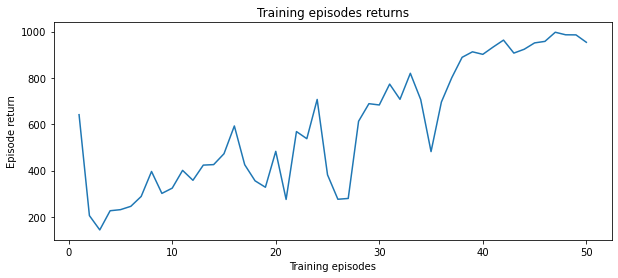

In [8]:
%matplotlib inline
df = pd.DataFrame(logger_dict['evaluator'].data)
plt.figure(figsize=(10, 4))
plt.title('Training episodes returns')
plt.xlabel('Training episodes')
plt.ylabel('Episode return')
plt.plot(df['actor_episodes'], df['episode_return'], label='Training Episodes return')